# Double Deep Q Learning - A simple hospital model

This is an example of a simple hospital bed model where a Reinforcement learning (RL) agent has to learn how to manage the bed stock:

    • Default arrivals = 50/day
    • Weekend arrival numbers are 50% average arrival numbers
    • Weekday arrival numbers are 120% average arrival numbers
    • Distribution of inter-arrival time is inverse exponential
    • Average length of stay is 7 days (default)
    • Distribution of length of stay is inverse exponential
    • The RL agent may request a change in bed numbers once a day (default)
    • The allowed bed change requests are -20, -10, 0, 10, 20
    • Bed changes take 2 days to occur (default)
    • The RL agent receives a reward at each action
        ◦ Reward of -1 for each unoccupied bed (default)
        ◦ Reward of -1.1 for each patients without a bed(default)
    • The simulation is loaded with the average number of patients present
    
The RL agent must learn to maximise the long term reward (return). The maximum reward = 0, so the agent is learning to minimise the loss for each unoccupied bed or patient without bed.

## Reinforcement learning introduction

### RL involves:
* Trial and error search
* Receiving and maximising reward (often delayed)
* Linking state -> action -> reward
* Must be able to sense something of their environment
* Involves uncertainty in sensing and linking action to reward
* Learning -> improved choice of actions over time
* All models find a way to balance best predicted action vs. exploration

### Elements of RL
* *Environment*: all observable and unobservable information relevant to us
* *Observation*: sensing the environment
* *State*: the perceived (or perceivable) environment 
* *Agent*: senses environment, decides on action, receives and monitors rewards
* *Action*: may be discrete (e.g. turn left) or continuous (accelerator pedal)
* *Policy* (how to link state to action; often based on probabilities)
* *Reward signal*: aim is to accumulate maximum reward over time
* *Value function* of a state: prediction of likely/possible long-term reward
* *Q*: prediction of likely/possible long-term reward of an *action*
* *Advantage*: The difference in Q between actions in a given state (sums to zero for all actions)
* *Model* (optional): a simulation of the environment

### Types of model

* *Model-based*: have model of environment (e.g. a board game)
* *Model-free*: used when environment not fully known
* *Policy-based*: identify best policy directly
* *Value-based*: estimate value of a decision
* *Off-policy*: can learn from historic data from other agent
* *On-policy*: requires active learning from current decisions


## Deep Q Networks for Reinforcement Learning

Q = The expected future rewards discounted over time. This is what we are trying to maximise.

The aim is to teach a network to take the current state observations and recommend the action with greatest Q.

<img src="./images/dqn.png" width="500"/>

Q is learned through the Bellman equation, where the Q of any state and action is the immediate reward achieved + the discounted maximum Q value (the best action taken) of next best action, where gamma is the discount rate.

$$Q(s,a)=r + \gamma.maxQ(s',a')$$

For a presenation on Q, see https://youtu.be/o22P5rCAAEQ

## Key DQN components

<img src="./images/dqn_components.png" width="600|"/>


## General method for Q learning:

Overall aim is to create a neural network that predicts Q. Improvement comes from improved accuracy in predicting 'current' understood Q, and in revealing more about Q as knowledge is gained (some rewards only discovered after time).

<img src="./images/dqn_process.png" width="600|"/>
    
Target networks are used to stabilise models, and are only updated at intervals. Changes to Q values may lead to changes in closely related states (i.e. states close to the one we are in at the time) and as the network tries to correct for errors it can become unstable and suddenly lose signficiant performance. Target networks (e.g. to assess Q) are updated only infrequently (or gradually), so do not have this instability problem.

## Training networks

Double DQN contains two networks. This ammendment, from simple DQN, is to decouple training of Q for current state and target Q derived from next state which are closely correlated when comparing input features.

The *policy network* is used to select action (action with best predicted Q) when playing the game.

When training, the predicted best *action* (best predicted Q) is taken from the *policy network*, but the *policy network* is updated using the predicted Q value of the next state from the *target network* (which is updated from the policy network less frequently). So, when training, the action is selected using Q values from the *policy network*, but the the *policy network* is updated to better predict the Q value of that action from the *target network*. The *policy network* is copied across to the *target network* every *n* steps (e.g. 1000).

<img src="./images/dqn_training.png" width="700|"/>

## Code structure

<img src="./images/dqn_program_structure.png" width="700|"/>

In [1]:
################################################################################
#                           1 Import packages                                  #
################################################################################

from simpy_envs.env_simple_hospital_bed_1 import HospGym

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim

# Use a double ended queue (deque) for memory
# When memory is full, this will replace the oldest value with the new one
from collections import deque

# Supress all warnings (e.g. deprecation warnings) for regular use
import warnings
warnings.filterwarnings("ignore")

In [2]:
################################################################################
#                           2 Define model parameters                          #
################################################################################

# Set whether to display on screen (slows model)
DISPLAY_ON_SCREEN = False
# Discount rate of future rewards
GAMMA = 0.95
# Learing rate for neural network
LEARNING_RATE = 0.001
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 1000000
# Sample batch size for policy network update
BATCH_SIZE = 5
# Number of game steps to play before starting training (all random actions)
REPLAY_START_SIZE = 365
# Time step between actions
TIME_STEP = 1
# Number of steps between policy -> target network update
SYNC_TARGET_STEPS = 365
# Exploration rate (episolon) is probability of choosign a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.999
# Simulation duration
SIM_DURATION = 365
# Training episodes
TRAINING_EPISODES = 25

In [3]:
################################################################################
#                      3 Define DQN (Deep Q Network) class                     #
#                    (Used for both policy and target nets)                    #
################################################################################

class DQN(nn.Module):

    """Deep Q Network. Udes for both policy (action) and target (Q) networks."""

    def __init__(self, observation_space, action_space):
        """Constructor method. Set up neural nets."""

        # Set starting exploration rate
        self.exploration_rate = EXPLORATION_MAX
        
        # Set up action space (choice of possible actions)
        self.action_space = action_space
              
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, 48),
            nn.ReLU(),
            nn.Linear(48, 48),
            nn.ReLU(),
            nn.Linear(48, action_space)
            )
        
        # Set loss function and optimizer
        self.objective = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.net.parameters(), lr=LEARNING_RATE)
        
        
    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""
        
        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.action_space)
            
        else:
            # Otherwise get predicted Q values of actions
            q_values = self.net(torch.FloatTensor(state))
            # Get index of action with best Q
            action = np.argmax(q_values.detach().numpy()[0])
        
        return  action
        
        
    def forward(self, x):
        """Forward pass through network"""
        return self.net(x)

In [4]:
################################################################################
#                    4 Define policy net training function                     #
################################################################################

def optimize(policy_net, target_net, memory):
    """
    Update  model by sampling from memory.
    Uses policy network to predict best action (best Q).
    Uses target network to provide target of Q for the selected next action.
    """
      
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < BATCH_SIZE:
        return    
 
    # Reduce exploration rate (exploration rate is stored in policy net)
    policy_net.exploration_rate *= EXPLORATION_DECAY
    policy_net.exploration_rate = max(EXPLORATION_MIN, 
                                      policy_net.exploration_rate)
    # Sample a random batch from memory
    batch = random.sample(memory, BATCH_SIZE)
    for state, action, reward, state_next, terminal in batch:
        
        state_action_values = policy_net(torch.FloatTensor(state))
        
        # Get target Q for policy net update
       
        if not terminal:
            # For non-terminal actions get Q from policy net
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach next state values from gradients to prevent updates
            expected_state_action_values = expected_state_action_values.detach()
            # Get next state action with best Q from the policy net (double DQN)
            policy_next_state_values = policy_net(torch.FloatTensor(state_next))
            policy_next_state_values = policy_next_state_values.detach()
            best_action = np.argmax(policy_next_state_values[0].numpy())
            # Get target net next state
            next_state_action_values = target_net(torch.FloatTensor(state_next))
            # Use detach again to prevent target net gradients being updated
            next_state_action_values = next_state_action_values.detach()
            best_next_q = next_state_action_values[0][best_action].numpy()
            updated_q = reward + (GAMMA * best_next_q)      
            expected_state_action_values[0][action] = updated_q
        else:
            # For termal actions Q = reward (-1)
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach values from gradients to prevent gradient update
            expected_state_action_values = expected_state_action_values.detach()
            # Set Q for all actions to reward (-1)
            expected_state_action_values[0] = reward
 
        # Set net to training mode
        policy_net.train()
        # Reset net gradients
        policy_net.optimizer.zero_grad()  
        # calculate loss
        loss_v = nn.MSELoss()(state_action_values, expected_state_action_values)
        # Backpropogate loss
        loss_v.backward()
        # Update network gradients
        policy_net.optimizer.step()  

    return

In [5]:
################################################################################
#                            5 Define memory class                             #
################################################################################

class Memory():
    """
    Replay memory used to train model.
    Limited length memory (using deque, double ended queue from collections).
      - When memory full deque replaces oldest data with newest.
    Holds, state, action, reward, next state, and episode done.
    """
    
    def __init__(self):
        """Constructor method to initialise replay memory"""
        self.memory = deque(maxlen=MEMORY_SIZE)

    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        self.memory.append((state, action, reward, next_state, done))

In [6]:
################################################################################
#                       6  Define results plotting function                    #
################################################################################

def plot_results(run, exploration, score, beds, patients):
    """Plot results at end of run"""
    
    # Set up chart (ax1 and ax2 share x-axis to combine two plots on one graph)
    fig = plt.figure(figsize=(9,5))
    ax1 = fig.add_subplot(121)
    ax2 = ax1.twinx()
    
    # Plot results
    average_rewards = np.array(score)/SIM_DURATION
    ax1.plot(run, exploration, label='exploration', color='g')
    ax2.plot(run, average_rewards, label='average reward', color='r')
    
    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('exploration', color='g')
    ax2.set_ylabel('average reward', color='r')
    
    # Show last run tracker of beds and patients

    ax3 = fig.add_subplot(122)
    day = np.arange(len(beds))*TIME_STEP
    ax3.plot(day, beds, label='beds', color='g')
    ax3.plot(day, patients, label='patients', color='r')
    
    # Set axes
    ax3.set_xlabel('day')
    ax3.set_ylabel('beds/patients')
    ax3.set_ylim(0)
    ax3.legend()
    ax3.grid()
    # Show
    
    plt.tight_layout(pad=2)
    plt.show()
    
    # Calculate summary results
    results = pd.Series()
    beds = np.array(beds)
    patients = np.array(patients)
    results['days under capacity'] = np.sum(patients > beds)
    results['days over capacity'] = np.sum(beds > patients)
    results['average patients'] = np.round(np.mean(patients), 0)
    results['average beds'] = np.round(np.mean(beds), 0)
    results['% occupancy'] = np.round((patients.sum() / beds.sum() * 100), 1)
    print (results);
    

In [7]:
################################################################################
#                                 7 Main program                               #
################################################################################


def hosp_bed_management():
    """Main program loop"""
    
    ############################################################################
    #                          8 Set up environment                            #
    ############################################################################
        
    # Set up game environemnt
    sim = HospGym(sim_duration=SIM_DURATION)

    # Get number of observations returned for state
    observation_space = sim.observation_size
    
    # Get number of actions possible
    action_space = sim.action_size
    
    ############################################################################
    #                    9 Set up policy and target nets                       #
    ############################################################################
    
    # Set up policy and target neural nets
    policy_net = DQN(observation_space, action_space)
    target_net = DQN(observation_space, action_space)
    
    # Copy weights from policy_net to target
    target_net.load_state_dict(policy_net.state_dict())
    
    # Set target net to eval rather than training mode
    # We do not train target net - ot is copied from policy net at intervals
    target_net.eval()
    
    ############################################################################
    #                            10 Set up memory                              #
    ############################################################################
        
    # Set up memomry
    memory = Memory()
    
    ############################################################################
    #                     11 Set up + start training loop                      #
    ############################################################################
    
    # Set up run counter and learning loop    
    run = 0
    all_steps = 0
    continue_learning = True
    
    # Set up list for results
    results_run = []
    results_exploration = []
    results_score = []
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        ########################################################################
        #                           12 Play episode                            #
        ########################################################################
        
        # Increment run (episode) counter
        run += 1
        
        ########################################################################
        #                             13 Reset game                            #
        ########################################################################
        
        # Reset game environment and get first state observations
        state = sim.reset()
        
        # Trackers for patents and beds
        beds = []
        patients = []        
        
        # Reset total reward
        total_reward = 0
        
        # Start time counter for steps in simulation
        next_stop = 0
        
        # Reshape state into 2D array with state obsverations as first 'row'
        state = np.reshape(state, [1, observation_space])
        
        # Reset step count for episode
        step = 0
        
        # Continue loop until episode complete
        while True:
            
        ########################################################################
        #                       14 Game episode loop                           #
        ########################################################################
            
            # Incrememnt step counts
            step += 1
            all_steps += 1
            
            ####################################################################
            #                       15 Get action                              #
            ####################################################################
            
            # Get action to take (se eval mode to avoid dropout layers)
            policy_net.eval()
            action = policy_net.act(state)
            
            ####################################################################
            #                 16 Play action (get S', R, T)                    #
            ####################################################################
            
            # Act
            state_next, reward, terminal, info = sim.step(action)
            total_reward += reward
            
            # Advance simulation ready for next action
            if not terminal:
                next_stop += TIME_STEP
                sim.env.run(until=next_stop)
                beds.append(state_next[1])
                patients.append(state_next[2])
                                                          
            # Reshape state into 2D array with state obsverations as first 'row'
            state_next = np.reshape(state_next, [1, observation_space])
            
            # Update display if needed
            if DISPLAY_ON_SCREEN:
                sim.render()
            
            ####################################################################
            #                  17 Add S/A/R/S/T to memory                      #
            ####################################################################
            
            # Record state, action, reward, new state & terminal
            memory.remember(state, action, reward, state_next, terminal)
            
            # Update state
            state = state_next
            
            ####################################################################
            #                  18 Check for end of episode                     #
            ####################################################################
            
            # Actions to take if end of game episode
            if terminal:
                # Get exploration rate
                exploration = policy_net.exploration_rate
                # Clear print row content
                clear_row = '\r' + ' '*79 + '\r'
                print (clear_row, end ='')
                print (f'Run: {run}, ', end='')
                print (f'Exploration: {exploration: .3f}, ', end='')
                average_reward = total_reward/SIM_DURATION
                print (f'Average reward: {average_reward:4.1f}', end='')
                
                # Add to results lists
                results_run.append(run)
                results_exploration.append(exploration)
                results_score.append(total_reward)
                
                ################################################################
                #             18b Check for end of learning                    #
                ################################################################
                
                if run == TRAINING_EPISODES:
                    continue_learning = False
                
                # End episode loop
                break
            
            
            ####################################################################
            #                        19 Update policy net                      #
            ####################################################################
            
            # Avoid training model if memory is not of sufficient length
            if len(memory.memory) > REPLAY_START_SIZE:
        
                # Update policy net
                optimize(policy_net, target_net, memory.memory)

                ################################################################
                #             20 Update target net periodically                #
                ################################################################
                
                # Use load_state_dict method to copy weights from policy net
                if all_steps % SYNC_TARGET_STEPS == 0:
                    target_net.load_state_dict(policy_net.state_dict())
                
    ############################################################################
    #                      21 Learning complete - plot results                 #
    ############################################################################
        
    # Target reached. Plot results
    plot_results(
        results_run, results_exploration, results_score, beds, patients)

Run: 25, Exploration:  0.010, Average reward: -48.1                            

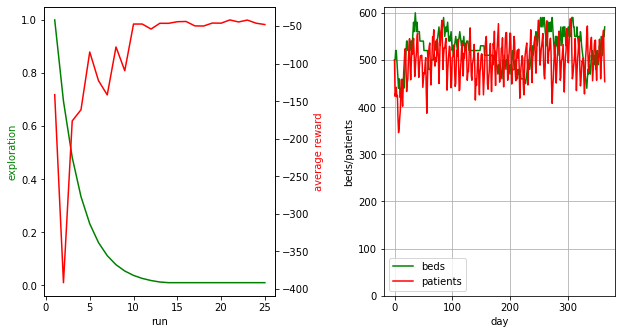

days under capacity    124.0
days over capacity     237.0
average patients       498.0
average beds           522.0
% occupancy             95.5
dtype: float64


In [8]:
hosp_bed_management()